# Work Notebook

In [123]:
import pandas as pd
import numpy as np
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE


pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

In [120]:
pd.set_option('display.max_colwidth', 100)

In [2]:
!ls data

xfiles.csv


In [3]:
df = pd.read_csv('data/xfiles.csv',encoding='unicode_escape' )

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [34]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize = True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327541
Negative emotion                      0.062692
I can't tell                          0.017158
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [7]:
df['emotion_in_tweet_is_directed_at'].value_counts().keys()

Index(['iPad', 'Apple', 'iPad or iPhone App', 'Google', 'iPhone',
       'Other Google product or service', 'Android App', 'Android',
       'Other Apple product or service'],
      dtype='object')

In [39]:
df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"].head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conf...,NaN,No emotion toward brand or product,NaN,New iPad Apps For SpeechTherapy And Communication Are Showcased At The SXSW Conference iear edch...,NaN
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product,NaN,Holler Gram for iPad on the iTunes App Store via is ken sxsw,NaN
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product,NaN,Attn All SXSW frineds Register for GDGTLive and see Cobra iRadar for Android link,NaN
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,NaN,Anyone at sxsw want to sell their old iPad,NaN
34,Anyone at #SXSW who bought the new iPad want to sell their older iPad to me?,NaN,No emotion toward brand or product,NaN,Anyone at SXSW who bought the new iPad want to sell their older iPad to me,NaN


In [8]:
products = {'Apple':'Apple','iPad':'Apple', 'iPad or iPhone App':'Apple','iPhone':'Apple','Other Apple product or service':'Apple',
            'Other Google product or service':'Google','Android App':'Google', 'Android':'Google', 'Google':'Google' }

In [9]:
df['brand'] = df['emotion_in_tweet_is_directed_at'].map(products)

In [10]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google


In [11]:
df.brand.value_counts()

Apple     2409
Google     882
Name: brand, dtype: int64

In [12]:
(df.brand.isna()).sum()

5802

In [28]:
df[df['emotion_in_tweet_is_directed_at'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,NaN,New iPad Apps For SpeechTherapy And Communicat...
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product,NaN,Holler Gram for iPad on the iTunes App Store v...
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product,NaN,Attn All SXSW frineds Register for GDGTLive an...
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,NaN,Anyone at sxsw want to sell their old iPad
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product,NaN,Anyone at SXSW who bought the new iPad want to...
...,...,...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product,NaN,Yup but I don t have a third app yet I m on An...
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,NaN,Wave buzz RT We interrupt your regularly sched...
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,NaN,Google s Zeiger a physician never reported pot...
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,NaN,Some Verizon iPhone customers complained their...


In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
tokenizer = RegexpTokenizer("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)")

In [16]:
def athash_remover(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression

In [17]:
df.drop(6, inplace= True)

In [18]:
df['tweet_text'].isna().sum()

0

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
 3   brand                                               3291 non-null   object
dtypes: object(4)
memory usage: 355.2+ KB


In [20]:
df['tweet_clean'] = df['tweet_text'].apply(athash_remover, )

In [21]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,Can not wait for iPad 2 also They should sale ...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,I hope this year s festival isn t as crashy as...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,great stuff on Fri SXSW Marissa Mayer Google T...


In [49]:
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({'Negative emotion':1, 'Positive emotion':2, 
                                                          'No emotion toward brand or product': 0})

In [56]:
df.dropna(axis = 0, subset = ['target'], inplace = True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 6 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   tweet_text                                          8936 non-null   object 
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object 
 2   is_there_an_emotion_directed_at_a_brand_or_product  8936 non-null   object 
 3   brand                                               3282 non-null   object 
 4   tweet_clean                                         8936 non-null   object 
 5   target                                              8936 non-null   float64
dtypes: float64(1), object(5)
memory usage: 488.7+ KB


In [2]:
mult_df = pd.read_csv('data/NLP_all_targets.csv', index_col=0)

In [3]:
mult_df.head()

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,target
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0,1.0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0,2.0
2,swonderlin wait ipad also sale sxsw,1.0,0.0,0.0,2.0
3,sxsw hope year's festival crashy year's iphone...,1.0,0.0,0.0,1.0
4,sxtxstate great stuff fri sxsw marissa mayer g...,0.0,1.0,0.0,2.0


In [4]:
mult_df['target'].value_counts()

0.0    5388
2.0    2978
1.0     570
Name: target, dtype: int64

In [83]:
# Creating the class that will store my data 
# @ David Hartsman
class Mult_Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, vectorizer, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision_macro', 'accuracy', 'recall_macro', 'f1_macro', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision_macro']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall_macro'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1_macro'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        # self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Mult_Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss}
        
        # Add the metrics to the class dataframe
        Mult_Model.model_df.loc[len(Mult_Model.model_df)] = self.attributes
        
        
        # Confusion Matrix Plot -> currently in init method
        fig, ax = plt.subplots(figsize=(7,7))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title("Confusion Matrix for Test Data");
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr)
        ax.set_title(f"{self.name} ROC Curve");
        
    def compare_roc_curve(self):
        # Color Palette
        colors = sns.color_palette(palette='gist_rainbow')
        # Create the plot
        fig, ax = plt.subplots(figsize=(10,10))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right');
    
    
    def __repr__(self):
      return f"Model name: ({self.model})"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

In [26]:
X = mult_df.drop('target', axis = 1)
y = mult_df.target

In [27]:
X.head(2)

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
0,wesley g iphone hr tweet rise austin dead need...,1.0,0.0,0.0
1,jessedee know fludapp awesome ipad iphone app ...,1.0,0.0,0.0


In [28]:
y.value_counts()

0.0    5388
2.0    2978
1.0     570
Name: target, dtype: int64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [44]:
X_train

,tokens,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing
5930,rt mention hotpot google marissameyer next cle...,0.0,1.0,0.0
4225,yawn rt mention apple set open pop shop sxsw i...,1.0,0.0,0.0
1711,bore sxsw try iphone app link,1.0,0.0,0.0
6825,rt mention google preview major new social ser...,0.0,1.0,0.0
4784,pleased see josh clark feature mention client ...,1.0,0.0,0.0
...,...,...,...,...
1817,watch talk guy hire jony ive apple sxsw indust...,1.0,0.0,0.0
3359,hey jen hear google circle sxsw link,0.0,1.0,0.0
4850,google era mention google look future mobile l...,0.0,1.0,0.0
3217,sxsw google wire party fun good info conferenc...,0.0,1.0,0.0


In [68]:
# Will vectorize tokenized data, and recombine it with our original X_train/test
def combine_train_vectorization(X, column, vectorizer):
    vector = vectorizer.fit_transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

def combine_test_vectorization(X, column, vectorizer):
    vector = vectorizer.transform(X[column])
    vector_df = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([X.drop(columns=column).reset_index(drop=True), vector_df.reset_index(drop=True)], axis=1)

In [100]:
tfidf_transformer = TfidfVectorizer()
v_count_transformer = CountVectorizer()

In [104]:
X_train_tfidf = combine_train_vectorization(X_train, 'tokens', tfidf_transformer)
X_train_vcount = combine_train_vectorization(X_train, 'tokens', v_count_transformer)

In [105]:
X_test_tfidf = combine_test_vectorization(X_test, 'tokens', tfidf_transformer)
X_test_vcount = combine_test_vectorization(X_test, 'tokens', v_count_transformer)

In [106]:
X_train_tfidf

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,aaron,aarpbulletin,ab,abandon,abba,abc,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6697,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6698,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6699,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6700,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Dummy

In [107]:
dummy.fit(X_train_tfidf,y_train)

DummyClassifier(strategy='most_frequent')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished


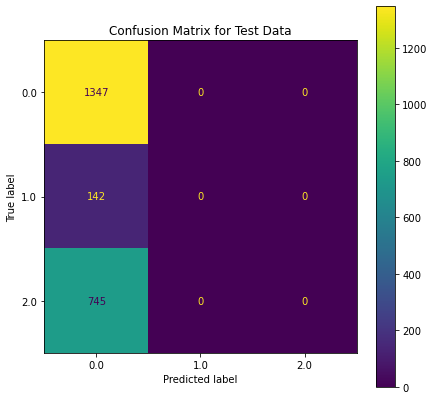

In [108]:
dummy_0 = Mult_Model("Dummy", dummy, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# MNB

In [109]:
mnb = MultinomialNB()

In [110]:
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [111]:
X_train_tfidf

,imputed_brand_Apple,imputed_brand_Google,imputed_brand_Missing,aapl,aaron,aarpbulletin,ab,abandon,abba,abc,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6697,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6698,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6699,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6700,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished
C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


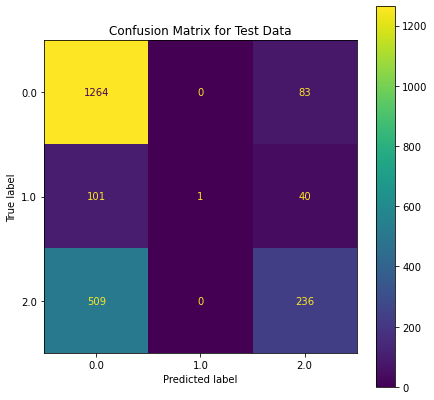

In [113]:
mnb1 = Mult_Model("MultNaiveBayes", mnb, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# MNB Count Vectorized

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished
C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


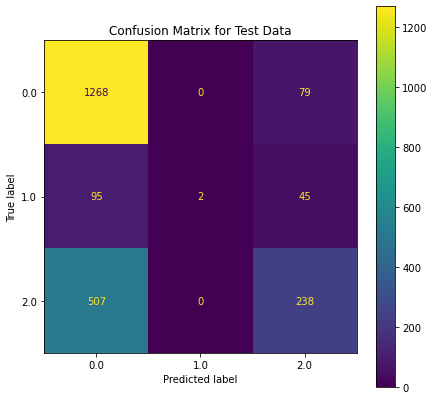

In [116]:
mnb2 = Mult_Model("MultNaiveBayes", mnb, v_count, X_train_vcount, X_test_vcount, y_train, y_test)

# Smote

In [122]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_tfidf, y_train)

In [148]:
smv = SMOTE(random_state=42)
X_vec, y_vec = smv.fit_resample(X_train_vcount, y_train)

# Random Forest

In [145]:
rndm_tfidf = RandomForestClassifier(random_state=42)
rndm_tfidf.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   34.7s finished


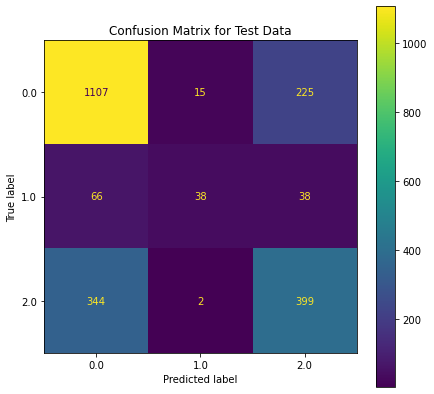

In [146]:
rndm_tfidf1 = Mult_Model("RNDM TFIDF Vect", rndm_tfidf, tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [147]:
Mult_Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.602954,0.200985,0.333333,0.250768,14.310976,0.602954,0.200985,0.333333,0.250768,14.310976,NaN
1,Dummy,0.602954,0.200985,0.333333,0.250768,14.310976,0.602954,0.200985,0.333333,0.250768,14.310976,NaN
2,Dummy,0.602954,0.200985,0.333333,0.250768,14.310976,0.602954,0.200985,0.333333,0.250768,14.310976,NaN
3,MultNaiveBayes,0.656668,0.430403,0.406035,0.389400,0.814117,0.671889,0.777292,0.420734,0.408791,0.793396,NaN
4,MultNaiveBayes,0.663086,0.550290,0.488353,0.499264,1.082601,0.675022,0.778511,0.424966,0.415360,1.388420,NaN
5,RNDM TFIDF Vect,0.685766,0.668533,0.487029,0.512702,0.776467,0.695166,0.668363,0.545995,0.578762,0.746083,NaN
6,RNDM TFIDF Vect,0.602954,0.200985,0.333333,0.250768,0.824848,0.555953,0.482766,0.558732,0.482642,1.054225,NaN
7,RNDM TFIDF Vect,0.605789,0.534890,0.336169,0.256831,0.806077,0.594002,0.501337,0.564065,0.511642,1.012295,NaN
8,RNDM TFIDF Vect,0.608325,0.455049,0.339774,0.266402,0.811022,0.586392,0.486369,0.517059,0.494738,1.000739,NaN
9,RNDM TFIDF Vect,0.670099,0.635215,0.475195,0.497904,2.266206,0.672337,0.620528,0.537475,0.564434,1.579171,NaN


In [149]:
rndm_vec = RandomForestClassifier(random_state=42)
rndm_vec.fit(X_vec, y_vec)

RandomForestClassifier(random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   44.1s finished


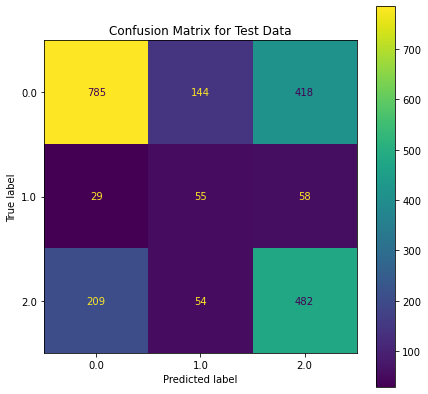

In [150]:
rndm_cvec = Mult_Model("RNDM Count Vect", rndm_vec, count_v, X_train_vcount, X_test_vcount, y_train, y_test)

In [152]:
Mult_Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.602954,0.200985,0.333333,0.250768,14.310976,0.602954,0.200985,0.333333,0.250768,14.310976,NaN
1,Dummy,0.602954,0.200985,0.333333,0.250768,14.310976,0.602954,0.200985,0.333333,0.250768,14.310976,NaN
2,Dummy,0.602954,0.200985,0.333333,0.250768,14.310976,0.602954,0.200985,0.333333,0.250768,14.310976,NaN
3,MultNaiveBayes,0.656668,0.430403,0.406035,0.389400,0.814117,0.671889,0.777292,0.420734,0.408791,0.793396,NaN
4,MultNaiveBayes,0.663086,0.550290,0.488353,0.499264,1.082601,0.675022,0.778511,0.424966,0.415360,1.388420,NaN
5,RNDM TFIDF Vect,0.685766,0.668533,0.487029,0.512702,0.776467,0.695166,0.668363,0.545995,0.578762,0.746083,NaN
6,RNDM TFIDF Vect,0.602954,0.200985,0.333333,0.250768,0.824848,0.555953,0.482766,0.558732,0.482642,1.054225,NaN
7,RNDM TFIDF Vect,0.605789,0.534890,0.336169,0.256831,0.806077,0.594002,0.501337,0.564065,0.511642,1.012295,NaN
8,RNDM TFIDF Vect,0.608325,0.455049,0.339774,0.266402,0.811022,0.586392,0.486369,0.517059,0.494738,1.000739,NaN
9,RNDM TFIDF Vect,0.670099,0.635215,0.475195,0.497904,2.266206,0.672337,0.620528,0.537475,0.564434,1.579171,NaN


In [ ]:
lr = LogisticRegression()

lr.fit